In [4]:
# Custom Input: Change the *custom_text* variable at the bottom of this code cell.
import torch
import torch.nn as nn
import pickle
import re
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, nhead=4, num_encoder_layers=2,
                 dim_feedforward=256, dropout=0.1, max_seq_len=200, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=max_seq_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(embed_dim, num_classes)
    
    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.pos_encoder(embedded)
        embedded = embedded.transpose(0, 1)
        transformer_out = self.transformer_encoder(embedded)
        pooled = transformer_out.mean(dim=0)
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        return logits.squeeze(1)


def clean_text(text):
    text = str(text).lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

def predict_sample(model, text, vocab, max_seq_len=200, device="cpu"):
    tokens = text.split()
    indices = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    if len(indices) < max_seq_len:
        indices = indices + [vocab["<pad>"]] * (max_seq_len - len(indices))
    else:
        indices = indices[:max_seq_len]
    tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor)
        prob = torch.sigmoid(output).item()
        prediction = 1 if prob >= 0.5 else 0
    return prediction, prob

def predict_custom_input(custom_text, model, vocab, max_seq_len=200, device="cpu"):
    custom_text = clean_text(custom_text)
    pred, conf = predict_sample(model, custom_text, vocab, max_seq_len=max_seq_len, device=device)
    label_mapping = {1: "True", 0: "Fake"}
    return label_mapping[pred], conf


model_save_path = "transformer_fake_news_model.pth"
vocab_save_path = "vocab.pkl"

with open(vocab_save_path, "rb") as f:
    vocab = pickle.load(f)

vocab_size = len(vocab)
max_seq_len = 200

model = TransformerClassifier(
    vocab_size=vocab_size,
    embed_dim=128,
    nhead=4,
    num_encoder_layers=2,
    dim_feedforward=256,
    dropout=0.1,
    max_seq_len=max_seq_len,
    num_classes=1
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model.eval()

if __name__ == "__main__":
    custom_text = "Joe Biden ignored murder by illegal immigrant in New York City" # Change this prompt
    predicted_label, confidence = predict_custom_input(custom_text, model, vocab, max_seq_len, device)
    print("Custom Input Prediction: ")
    print("(Only works on US geopolitics and internal politics between 2016 and 2017 due to the nature of the dataset)")
    print("------------------------")
    print(f"Input Text       : {custom_text}")
    print(f"Predicted Label  : {predicted_label}")
    print(f"Confidence Score (0 for Fake, 1 for True): {confidence:.4f}")

Custom Input Prediction: 
(Only works on US geopolitics and internal politics between 2016 and 2017 due to the nature of the dataset)
------------------------
Input Text       : Joe Biden ignored murder by illegal immigrant in New York City
Predicted Label  : Fake
Confidence Score (0 for Fake, 1 for True): 0.0001


---------------------

In [5]:
# Testing model on some random samples from the dataset.
import pandas as pd

def clean_text(text):
    text = str(text).lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

def predict_sample(model, text, vocab, max_seq_len=200):
    model.eval()
    tokens = text.split()
    indices = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    if len(indices) < max_seq_len:
        indices = indices + [vocab["<pad>"]] * (max_seq_len - len(indices))
    else:
        indices = indices[:max_seq_len]
    tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor)
        prob = torch.sigmoid(output).item()
        prediction = 1 if prob >= 0.5 else 0
    return prediction, prob

label_mapping = {1: "True", 0: "Fake"}

true_df = pd.read_csv('news_dataset/True.csv')
fake_df = pd.read_csv('news_dataset/Fake.csv')

true_df['label'] = 1
fake_df['label'] = 0

true_df['content'] = true_df['title'].fillna('') + " " + true_df['text'].fillna('')
fake_df['content'] = fake_df['title'].fillna('') + " " + fake_df['text'].fillna('')

df = pd.concat([true_df, fake_df]).reset_index(drop=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['content'] = df['content'].apply(clean_text)

sample_df = pd.concat([
    df[df['label'] == 1].sample(5),
    df[df['label'] == 0].sample(5)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print("\nSample Predictions:")
print("-------------------")
for idx, row in sample_df.iterrows():
    pred, conf = predict_sample(model, row['content'], vocab, max_seq_len=max_seq_len)
    text_preview = row['content'][:200] + ("..." if len(row['content']) > 200 else "")
    print("-----")
    print(f"Text Preview      : {text_preview}")
    print(f"Original Label    : {label_mapping[row['label']]}")
    print(f"Predicted Label   : {label_mapping[pred]}")
    print(f"Confidence Score  : {conf:.4f}")
    print("-----\n")


Sample Predictions:
-------------------
-----
Text Preview      : sarah huckabee sanders fcking unbelievably awful defense of trumps mika tweets video on thursday donald trump truly became the president he bravely stood up to the fake news media by tweeting about ms...
Original Label    : Fake
Predicted Label   : Fake
Confidence Score  : 0.0001
-----

-----
Text Preview      : islamic states footprint spreading in northern somalia un nairobi reuters  a militant faction loyal to islamic state is has increased its following in northern somalia from a few dozen last year to up...
Original Label    : True
Predicted Label   : True
Confidence Score  : 0.9999
-----

-----
Text Preview      : starbucks customer in chicago goes on insane racist rant youve never heard anything like this video a young white man in chicago became an internet sensation and a probable future excon after on tuesd...
Original Label    : Fake
Predicted Label   : Fake
Confidence Score  : 0.0003
-----

-----
Text Previe

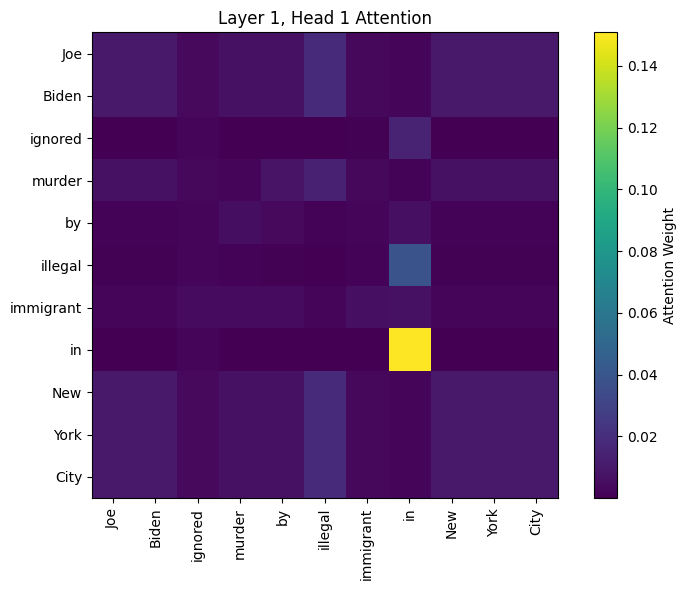

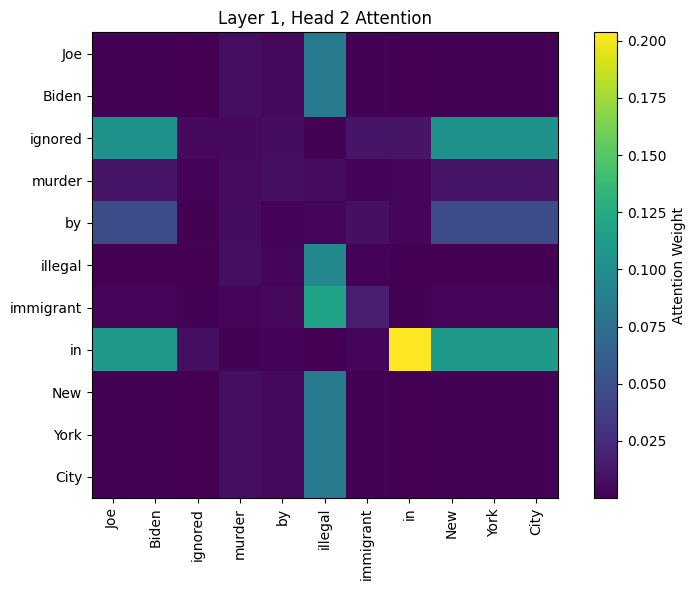

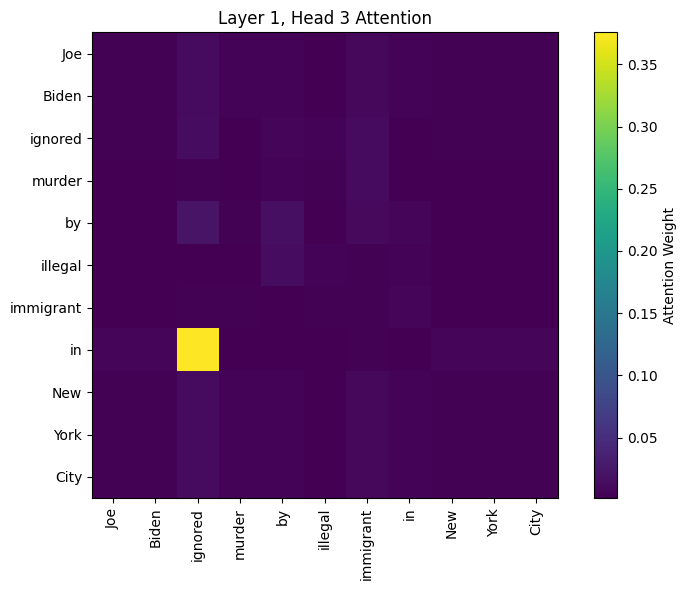

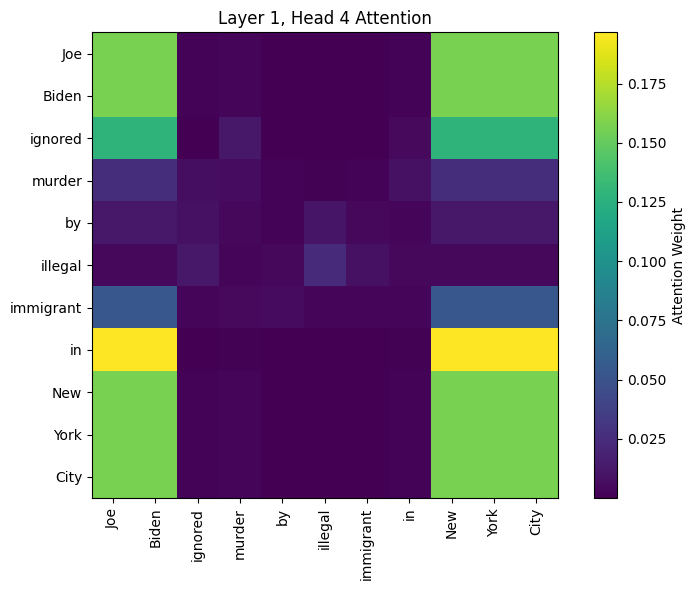

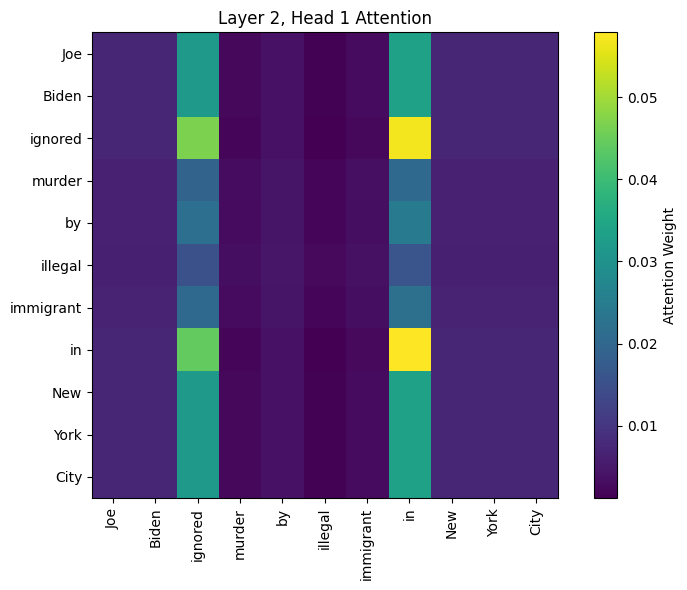

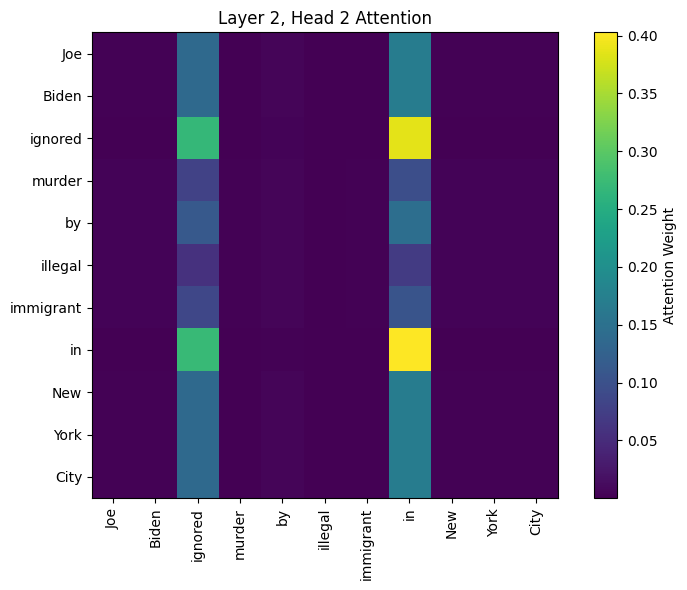

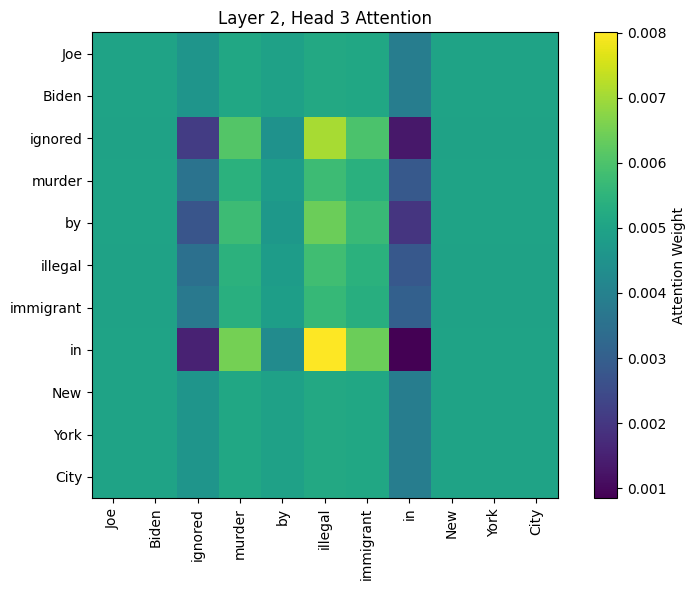

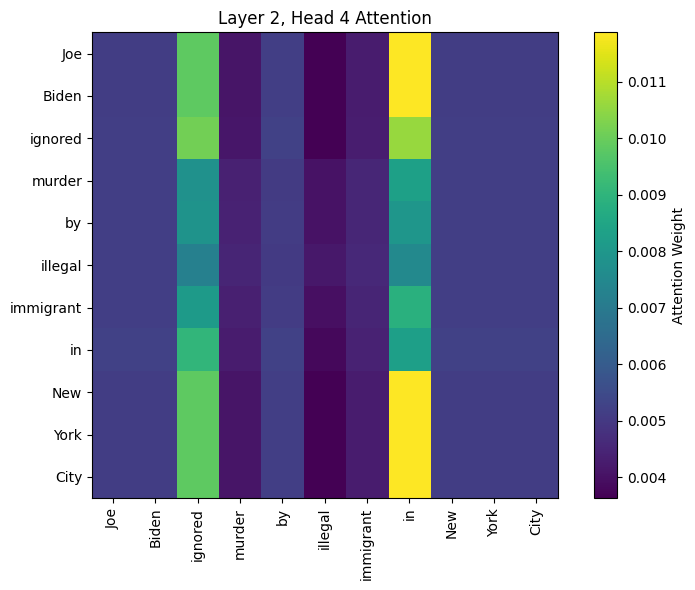

In [6]:
# Visualizing the Attention for token.
def patch_attention_modules(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.MultiheadAttention):
            orig_forward = module.forward
            def forward_with_weights(query, key, value, **kwargs):
                return orig_forward(query, key, value, need_weights=True,
                                     average_attn_weights=False, **kwargs)
            module.forward = forward_with_weights

patch_attention_modules(model)

def get_attention_for_sentence(model, sentence, vocab, max_seq_len=200, device="cpu"):
    model.eval()
    tokens = sentence.split()
    idxs   = [vocab.get(t, vocab["<unk>"]) for t in tokens][:max_seq_len]
    idxs  += [vocab["<pad>"]] * (max_seq_len - len(idxs))
    x = torch.tensor(idxs, dtype=torch.long).unsqueeze(1).to(device)  # [seq_len, batch=1]
    
    emb = model.embedding(x)
    emb = model.pos_encoder(emb)
    
    out = emb
    attn_maps = []  # collect (heads, seq, seq)
    for enc_layer in model.transformer_encoder.layers:
        out, weights = enc_layer.self_attn(out, out, out)
        attn_maps.append(weights.squeeze(0).cpu().detach().numpy())
    
    return tokens, attn_maps

for i in range(2):
    for j in range(4):
        tokens, maps = get_attention_for_sentence(model, custom_text, vocab, max_seq_len, device)

        layer_idx = i
        head_idx  = j
        attn = maps[layer_idx][head_idx]

        N = len(tokens)
        attn = attn[:N, :N]

        plt.figure(figsize=(8,6))
        plt.imshow(attn, cmap='viridis')
        plt.colorbar(label='Attention Weight')
        plt.xticks(range(N), tokens, rotation=90)
        plt.yticks(range(N), tokens)
        plt.title(f'Layer {layer_idx+1}, Head {head_idx+1} Attention')
        plt.tight_layout()
        plt.savefig(f'images/l{i+1}h{j+1}.png')
        plt.show()